In [44]:
import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.pyplot as plt

In [45]:
class RBF(torch.nn.Module):
      def __init__(self, sigma=None):
        super(RBF, self).__init__()

        self.sigma = sigma

      def forward(self, X, Y):
        XX = X.matmul(X.t())
        XY = X.matmul(Y.t())
        YY = Y.matmul(Y.t())

        dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

        # Apply the median heuristic (PyTorch does not give true median)
        if self.sigma is None:
          np_dnorm2 = dnorm2.detach().cpu().numpy()
          h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
          sigma = np.sqrt(h).item()
        else:
          sigma = self.sigma

        gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
        K_XY = (-gamma * dnorm2).exp()

        return K_XY
  
# Let us initialize a reusable instance right away.
K = RBF()

In [46]:
class SVGD:
      def __init__(self, P, K, optimizer):
        self.P = P
        self.K = K
        self.optim = optimizer

      def phi(self, X):
        X = X.detach().requires_grad_(True)

        log_prob = self.P.log_prob(X)
        score_func = autograd.grad(log_prob.sum(), X)[0]
        K_XX = self.K(X, X.detach())
        grad_K = -autograd.grad(K_XX.sum(), X)[0]
        phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

        return phi

      def step(self, X):
        self.optim.zero_grad()
        X.grad = -self.phi(X)
        self.optim.step()   

In [47]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define target distribution: Multivariate Gaussian
mu = torch.tensor([20.0, -10.0], device=device)
cov = torch.tensor([[1.0, 0.8], [0.8, 1.0]], device=device)
P = torch.distributions.MultivariateNormal(mu, covariance_matrix=cov)

n_particles = 20
X_tar = P.sample((50,))

X_init = torch.randn(n_particles, 2, device=device) #* 1.5
X_t = X_init.clone()
svgd = SVGD(P, K, optim.Adam([X_t], lr=1e-1))

trajectories = [X.clone().cpu()]
for _ in range(100):
    svgd.step(X)
    trajectories.append(X_t.clone().cpu())
    
trajectories = torch.stack(trajectories)    

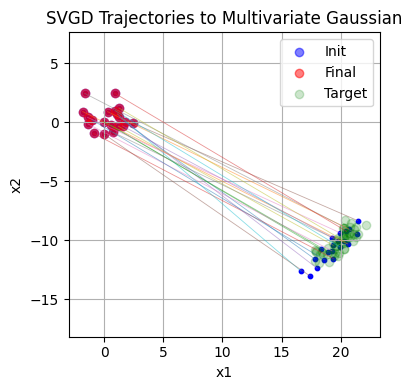

In [48]:
plt.figure(figsize=(4, 4))
for i in range(n_particles):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], lw=0.6, alpha=0.5)
    plt.scatter(trajectories[0, i, 0], trajectories[0, i, 1], c='blue', s=10)   # Start
    plt.scatter(trajectories[-1, i, 0], trajectories[-1, i, 1], c='red', s=10)  # End

# Overlay true samples
plt.scatter(X_init[:, 0].cpu(), X_init[:, 1].cpu(), alpha=0.5, color="blue", label="Init")
plt.scatter(X_t[:, 0].cpu(), X_t[:, 1].cpu(), alpha=0.5, color="red", label="Final")
plt.scatter(X_tar[:, 0].cpu(), X_tar[:, 1].cpu(), alpha=0.2, color="green", label="Target")
plt.title("SVGD Trajectories to Multivariate Gaussian")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()